In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy_langdetect import LanguageDetector
import googletrans
from googletrans import Translator
import time
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
# Download stop words
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
print(googletrans.__version__)

4.0.0-rc.1


In [6]:
df = pd.read_csv('data/sentences.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22322 entries, 0 to 22321
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sen_id           22322 non-null  object
 1   review           22322 non-null  object
 2   rating           22322 non-null  int64 
 3   sentences        18399 non-null  object
 4   sentence_length  22322 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 872.1+ KB


In [7]:
# Remove rows with missing values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18399 entries, 0 to 22321
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sen_id           18399 non-null  object
 1   review           18399 non-null  object
 2   rating           18399 non-null  int64 
 3   sentences        18399 non-null  object
 4   sentence_length  18399 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 862.5+ KB


# SEPARATE VIETNAMESE AND ENGLISH

In [8]:
df.head()

,sen_id,review,rating,sentences,sentence_length
0,1.1.1,It is such a nice and romantic restaurant for ...,5,It is such a nice and romantic restaurant for ...,100
1,1.1.1,It is such a nice and romantic restaurant for ...,5,\nFood is so nice with western courses,37
2,1.1.1,It is such a nice and romantic restaurant for ...,5,Drinks are interesting to enjoy,32
3,1.1.1,It is such a nice and romantic restaurant for ...,5,We had a very nice dinner with our boss and c...,55
4,1.1.1,It is such a nice and romantic restaurant for ...,5,Thank you for nice preparation as well,39


## Test Google trans

In [5]:
translator = Translator()
translator.detect('Quán nằm trong 1 con đường nhỏ, diện tích quán cũng nhỏ nhưng bù lại decor theo phong cách châu Âu rất đẹp và sang trọng.').lang

'vi'

In [10]:
translator.detect('The restaurant is located in a small street, the area is small but the decor is very beautiful and luxurious in European style.').lang

'en'

In [15]:
df_review = pd.read_csv('data/reviews.csv')
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11208 entries, 0 to 11207
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   res_id  11208 non-null  int64 
 1   review  9308 non-null   object
 2   rating  11208 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 262.8+ KB


In [16]:
df_review.dropna(inplace=True)
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9308 entries, 0 to 11157
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   res_id  9308 non-null   int64 
 1   review  9308 non-null   object
 2   rating  9308 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 290.9+ KB


In [181]:
9308-7767

1541

## Label language for each review

In [152]:
# assign id to reviews with the partern res_id + '.' + auto-increment number
df_review['review_id'] = df_review.groupby('res_id').cumcount() + 1

# Combine 'res_id' and the sequential count to create the 'id' column
df_review['review_id'] = df_review['res_id'].astype(str) + '.' + df_review['review_id'].astype(str)

In [117]:
# insert language column with empty value
empty_list = [np.nan] * len(df_review)
df_review.insert(3, 'language', empty_list)

In [153]:
#reorder columns
df_review = df_review[['review_id', 'rating' 'review', 'language']]
df_review.head()

,review_id,res_id,review,language
0,1.1,1,It is such a nice and romantic restaurant for ...,en
1,1.2,1,Food is marvelous.\nWe ordered the French onio...,en
2,1.3,1,One of those fine dining experience I have in ...,en
3,1.4,1,I have the 4 course set is around HKD 2XX per ...,en
4,1.5,1,"Fav place in sgn\nAmazing food, luxurious atmo...",en


In [ ]:
end = 0 # start from 0

In [198]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9308 entries, 0 to 9307
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  9308 non-null   object
 1   rating     9308 non-null   int64 
 2   review     9308 non-null   object
 3   language   1552 non-null   object
dtypes: int64(1), object(3)
memory usage: 363.6+ KB


In [ ]:
# label language with break
# Because too many requests, I have to break the loop
begin = end
for i in tqdm(range(begin,len(df_review))):
    lang = translator.detect(df_review.iloc[i]['review']).lang
    df_review.iloc[i,3] = lang
    end = i

In [271]:
df_review['language'].value_counts()

en       4769
vi       4516
ar          4
lb          2
mr          2
ms          2
ja          1
la          1
mi          1
hi          1
jw          1
it          1
haw         1
es          1
nl          1
zh-CN       1
de          1
om          1
lv          1
Name: language, dtype: int64

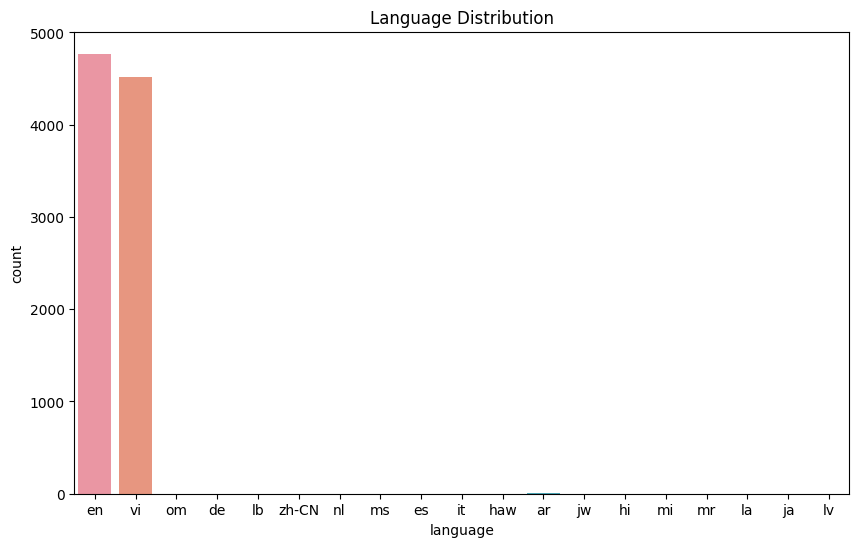

In [272]:
# plot language distribution
plt.figure(figsize=(10,6))
sns.countplot(x='language', data=df_review)
plt.title('Language Distribution')
plt.show()

In [273]:
df_en = df_review[df_review['language'] == 'en']
df_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4769 entries, 0 to 9282
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  4769 non-null   object
 1   rating     4769 non-null   int64 
 2   review     4769 non-null   object
 3   language   4769 non-null   object
dtypes: int64(1), object(3)
memory usage: 186.3+ KB


In [274]:
df_vi = df_review[df_review['language'] == 'vi']
df_vi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4516 entries, 77 to 9306
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  4516 non-null   object
 1   rating     4516 non-null   int64 
 2   review     4516 non-null   object
 3   language   4516 non-null   object
dtypes: int64(1), object(3)
memory usage: 176.4+ KB


In [275]:
df_en.to_csv('data/reviews_en.csv', index=False)
df_vi.to_csv('data/reviews_vi.csv', index=False)

In [276]:
df_review = pd.read_csv('data/reviews.csv')

# Split into sentences

In [15]:
df_en = pd.read_csv('data/reviews_en.csv')

In [16]:
df_en.head()

,review_id,rating,review,language
0,1.1,5,It is such a nice and romantic restaurant for ...,en
1,1.2,4,Food is marvelous.\nWe ordered the French onio...,en
2,1.3,5,One of those fine dining experience I have in ...,en
3,1.4,5,I have the 4 course set is around HKD 2XX per ...,en
4,1.5,5,"Fav place in sgn\nAmazing food, luxurious atmo...",en


In [17]:
# split df_en into sentences with one sentence per row
df_en_sentences = df_en[['review_id','review']].assign(review=df_en['review'].str.split('.')).explode('review')

In [18]:
df_en_sentences.head(20)

,review_id,review
0,1.1,It is such a nice and romantic restaurant for ...
0,1.1,\nFood is so nice with western courses
0,1.1,Drinks are interesting to enjoy
0,1.1,We had a very nice dinner with our boss and c...
0,1.1,Thank you for nice preparation as well
0,1.1,
1,1.2,Food is marvelous
1,1.2,\nWe ordered the French onion soup which is my...
1,1.2,\nThe pear salad my friend loved it very much
1,1.2,\nThe beef is good but the lamp rack is excell...


In [19]:
# split df_review into sentences with one sentence per row by /n 
df_review_sentences = df_en['review'].to_frame().assign(review=df_en['review'].str.split('\n')).explode('review')

In [20]:
df_en_sentences.head(20)

,review_id,review
0,1.1,It is such a nice and romantic restaurant for ...
0,1.1,\nFood is so nice with western courses
0,1.1,Drinks are interesting to enjoy
0,1.1,We had a very nice dinner with our boss and c...
0,1.1,Thank you for nice preparation as well
0,1.1,
1,1.2,Food is marvelous
1,1.2,\nWe ordered the French onion soup which is my...
1,1.2,\nThe pear salad my friend loved it very much
1,1.2,\nThe beef is good but the lamp rack is excell...


In [21]:
df_en_sentences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11067 entries, 0 to 4768
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review_id  11067 non-null  float64
 1   review     11067 non-null  object 
dtypes: float64(1), object(1)
memory usage: 259.4+ KB


In [22]:
# remove empty rows
df_en_sentences.dropna(inplace=True)
df_en_sentences = df_en_sentences[df_en_sentences['review'] != '']
df_en_sentences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9035 entries, 0 to 4768
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review_id  9035 non-null   float64
 1   review     9035 non-null   object 
dtypes: float64(1), object(1)
memory usage: 211.8+ KB


## Cleaning data - English reviews

### Remove special character

In [23]:
#remove html tags
df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: re.sub(r'<.*?>', '', x))
#remove special characters
df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', x))
#remove extra spaces
df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: re.sub(r'\s+', ' ', x))
#remove break line
df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: re.sub(r'\n', '', x))
df_en_sentences.head(20)

,review_id,review
0,1.1,It is such a nice and romantic restaurant for ...
0,1.1,Food is so nice with western courses
0,1.1,Drinks are interesting to enjoy
0,1.1,We had a very nice dinner with our boss and c...
0,1.1,Thank you for nice preparation as well
1,1.2,Food is marvelous
1,1.2,We ordered the French onion soup which is my ...
1,1.2,The pear salad my friend loved it very much
1,1.2,The beef is good but the lamp rack is excelle...
1,1.2,"There are three things that worth comment, th..."


In [24]:
#remove comma, dot, question mark, exclamation mark, colon, semicolon, slash, quotation mark
df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: re.sub(r'[.,!?/:;\"\'\s]', ' ', x))
df_en_sentences.sample(20)

,review_id,review
3989,157.130,food dish is ok and restaurant have a big park...
3331,144.990,Amazing food and fabulous service
3045,141.420,Good
3995,157.190,Car parking is on the road
2186,92.400,A modern wedding venue
2688,103.120,Delicious fast food for now after feeling so h...
122,7.500,Very delicious foods
773,25.440,Good Korean food restaurant nearby superbowl
3250,144.180,A bit of a shame
315,8.107,Good place


In [25]:
# remove sentences with less than 2 words: becase they don't have enough information
df_en_sentences['word_count'] = df_en_sentences['review'].apply(lambda x: len(x.split()))
df_en_sentences = df_en_sentences[df_en_sentences['word_count'] > 2]
df_en_sentences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6903 entries, 0 to 4768
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   review_id   6903 non-null   float64
 1   review      6903 non-null   object 
 2   word_count  6903 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 215.7+ KB


### Replace abbreviations

In [32]:
# abbreviation dictionary
abbr_dict={
    "what s":"what is",
    "whatre":"what are",
    "whos":"who is",
    "who re":"who are",
    "wheres":"where is",
    "wherere":"where are",
    "whens":"when is",
    "whenre":"when are",
    "hows":"how is",
    "howre":"how are",

    "i m":"i am",
    "you re":"you are",
    "they re":"they are",
    "he s":"he is",
    "she s":"she is",
    "that s":"that is",
    "there s":"there is",
    "therer e":"there are",

    "i ve":"i have",
    "we ve":"we have",
    "you ve":"you have",
    "they ve":"they have",
    "who ve":"who have",
    "would ve":"would have",
    "not ve":"not have",

    "youll":"you will",
    "hell":"he will",
    "shell":"she will",
    "itll":"it will",
    "theyll":"they will",

    "isn t":"is not",
    "wasn t":"was not",
    "aren t":"are not",
    "weren t":"were not",
    "can t":"can not",
    "couldn t":"could not",
    "don t":"do not",
    "didn t":"did not",
    "shouldn t":"should not",
    "wouldn t":"would not",
    "doesnt":"does not",
    "haven t":"have not",
    "hasn t":"has not",
    "hadn t":"had not",
    "hcm" : "ho chi minh",
    "hcmc" : "ho chi minh city",
    "sg" : "saigon",
    "saigon" : "ho chi minh city",
    "u" : "you",
    "ur" : "your",
    "r" : "are",
    "thx" : "thanks",
    "thks" : "thanks",
    "rib" : "riverside",
    "ok" : "okay",
    "oke" : "okay",
    "okk" : "okay",
    "mill" : "million",
    "wana" : "want to",
    "wanna" : "want to",
    "Goooooood" : "good",
    
}

In [33]:
#replace abbreviation
df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: ' '.join([abbr_dict[word] if word in abbr_dict.keys() else word for word in x.split()]))
df_en_sentences.sample(20)

,review_id,review,word_count
3294,144.620,If i could 0 stars I would,7
1102,33.810,Better arrive before 12am about 30 minutes,7
544,15.520,Food 4 5 Attitude 3 5 Place 3 5,9
1100,33.790,Food is fresh service is fast and good,8
237,8.290,Credit card accepted,3
2603,98.300,They server a lot local food like Pho,8
1932,70.320,Korean taste is less To settle a meal in a for...,13
921,31.400,The taste was great,4
37,1.380,The beef is not tenderloin but Wagyu striploin...,18
1865,68.220,Good place for meeting food,5


In [36]:
#create sentence id
df_en_sentences['sentence_id'] = df_en_sentences.groupby('review_id').cumcount() + 1
df_en_sentences['sentence_id'] = df_en_sentences['review_id'].astype(str) + '.' + df_en_sentences['sentence_id'].astype(str)
df_en_sentences = df_en_sentences[['sentence_id', 'review_id', 'review', 'word_count']]
df_en_sentences.head(20)

,sentence_id,review_id,review,word_count
0,1.1.1,1.1,It is such a nice and romantic restaurant for ...,18
0,1.1.2,1.1,Food is so nice with western courses,7
0,1.1.3,1.1,Drinks are interesting to enjoy,5
0,1.1.4,1.1,We had a very nice dinner with our boss and co...,11
0,1.1.5,1.1,Thank you for nice preparation as well,7
1,1.2.1,1.2,Food is marvelous,3
1,1.2.2,1.2,We ordered the French onion soup which is my f...,13
1,1.2.3,1.2,The pear salad my friend loved it very much,9
1,1.2.4,1.2,The beef is good but the lamp rack is excellen...,21
1,1.2.5,1.2,There are three things that worth comment the ...,27


In [37]:
df_en_sentences.to_csv('data/reviews_en_sentences.csv', index=False)

### Lowercase

In [38]:
#lowercase
df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: x.lower())
#random 20 rows
df_en_sentences.sample(20)

,sentence_id,review_id,review,word_count
3269,144.37.2,144.370,vietnamese food in this restaurant is very del...,15
3687,151.29.1,151.290,a beautiful interior complements the fantastic...,17
1077,33.56.1,33.560,fine quality food,3
327,11.2.5,11.200,the waiters are not really nice,6
974,31.57.1,31.570,a long history restaurant at superbowl saigon,7
2168,89.45.2,89.450,these days it s strangely delicious,6
311,8.103.1,8.103,wait too long,3
4291,162.99.3,162.990,their waiter speaks good english which helps a...,11
2564,97.67.1,97.670,pricey but worthy,3
2134,84.4.5,84.400,we ended up paying double,5


### Remove stopwords

In [41]:
stopwords_list = stopwords.words('english')

In [42]:
#try to remove stop words
print(df_en_sentences['review'].iloc[0])
text_removed = ' '.join([word for word in df_en_sentences['review'].iloc[0].split() if word not in stopwords_list])
print(text_removed)

it is such a nice and romantic restaurant for new couples and family getting back the sweet memories
nice romantic restaurant new couples family getting back sweet memories


In [43]:
#remove stop words
df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_list]))
df_en_sentences.sample(20)

,sentence_id,review_id,review,word_count
3448,148.9.1,148.900,fancy place dinner,5
4256,162.64.2,162.640,ordered coconut fried rice chicken,8
2164,89.38.1,89.380,whole house especially good mental health eat ...,17
3843,154.7.4,154.700,aluminum known cause alzheimer lead poisoning ...,16
1467,50.63.1,50.630,good beer food quite expensive,6
2849,106.5.2,106.500,well trained staff friendly helpful staff reme...,16
1863,68.2.5,68.200,nice relax place,4
3678,151.2.6,151.200,really enjoyed food service,8
2996,140.128.1,140.128,expensive offer,4
2866,106.63.2,106.630,speed buffet comes,9


### Lemmatizing

In [44]:
lemmatizer = WordNetLemmatizer()

df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df_en_sentences.sample(20)

,sentence_id,review_id,review,word_count
4213,162.21.8,162.210,overall nice experience eating,8
978,31.61.1,31.610,many kind,4
1188,35.2.1,35.200,really big bowl pho save last 1000k dong enjoy...,18
2135,84.5.3,84.500,food average considering pletora delicious foo...,18
4512,165.59.2,165.590,hair har gow,5
4449,163.158.1,163.158,average food sitting,4
1462,50.58.1,50.580,good beer golden one better,7
2701,103.25.2,103.250,fast,3
2897,140.29.4,140.290,eat another noodle bowl street vendor better t...,17
1685,63.18.2,63.180,menu varies serving time bit slow quality go p...,20


In [46]:
df_en_sentences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6903 entries, 0 to 4768
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sentence_id  6903 non-null   object 
 1   review_id    6903 non-null   float64
 2   review       6903 non-null   object 
 3   word_count   6903 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 269.6+ KB


In [47]:
#remove rows with length less than 2
df_en_sentences['word_count'] = df_en_sentences['review'].apply(lambda x: len(str(x).split()))
df_en_sentences = df_en_sentences[df_en_sentences['word_count'] >= 2]
df_en_sentences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6794 entries, 0 to 4768
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sentence_id  6794 non-null   object 
 1   review_id    6794 non-null   float64
 2   review       6794 non-null   object 
 3   word_count   6794 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 265.4+ KB


In [48]:
df_en_sentences.sample(20)

,sentence_id,review_id,review,word_count
3178,143.11.4,143.110,extensive menu dish name english picture,6
4575,165.122.1,165.122,good food service,3
2511,97.14.2,97.140,good atmosphere drink food delicious,5
1733,63.66.1,63.660,good quality friendly staff tasty,5
1042,33.21.1,33.210,alright got dynamite salmon edamame pork cutle...,8
2347,96.2.2,96.200,food also delicious good price,5
920,31.3.6,31.300,lovely crispy french fry well,5
1679,63.12.3,63.120,absolutely worth visiting came monday received...,14
2399,96.54.2,96.540,chicken spicy curry,3
2037,74.46.1,74.460,house went since second floor super bowl,7


In [49]:
#remove digits because they don't have much meaning
df_en_sentences['review'] = df_en_sentences['review'].apply(lambda x: re.sub(r'\d+', '', x))
df_en_sentences.sample(20)

,sentence_id,review_id,review,word_count
2203,92.21.1,92.21,many people smoking wife pregnant hated,6
646,21.36.1,21.36,great place bite,3
60,1.61.1,1.61,atmosphere nice food,3
4652,168.6.1,168.60,restaurant seafood calm quite environment dine...,7
395,12.61.1,12.61,good happy event,3
2395,96.5.2,96.50,really delicious indian restaurant know locati...,11
189,7.73.1,7.73,enjoy favourite food,3
1185,34.4.1,34.40,eat various part goat breast meat brain miso,8
29,1.3.11,1.30,lo behold took one drink bug cancel two entree...,14
1742,63.75.13,63.75,unfortunately paired accompanying sauce mayonn...,8


In [50]:
#update word count
df_en_sentences['word_count'] = df_en_sentences['review'].apply(lambda x: len(str(x).split()))
df_en_sentences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6794 entries, 0 to 4768
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sentence_id  6794 non-null   object 
 1   review_id    6794 non-null   float64
 2   review       6794 non-null   object 
 3   word_count   6794 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 265.4+ KB


In [51]:
df_en_sentences.to_csv('data/reviews_en_sentences_cleaned.csv', index=False)